In [454]:
import datetime as dt
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns
%matplotlib inline

#Size of matplotlib plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [18]:
pd.__version__

'1.0.3'

## The next cell loads data from the John Hopkins github repository on the Corona virus: https://github.com/CSSEGISandData/COVID-19

If you want to run this code, make sure that the paths below are correctly pointing to a copy of the John Hopkins repository.

In [411]:
today = dt.date.today(); today

datetime.date(2020, 4, 3)

In [456]:
#Load data locally
data_confirmed = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
data_deaths = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
data_recovered = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
#Load data from Internet
#data_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
#data_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
#data_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

data = [data_confirmed, data_deaths, data_recovered]

#mask = data_confirmed_orig.drop(["Lat","Long"], axis = 1).sum(numeric_only=True, axis=1)>100
for i in range(len(data)):
    #d.loc[d["Province/State"].notna(), "Country/Region"] += ' ' + d.loc[d["Province/State"].notna(), "Province/State"]
    try:
        data[i].drop(["Province/State", "Lat", "Long"] ,axis = 1, inplace=True)
        data[i]=data[i].groupby('Country/Region').sum()
    except KeyError:
        pass
    cols = data[i].columns
    new_cols = map(lambda x: dt.date(2020,*[int(x.split('/')[k]) for k in [0,1]]), cols)
    #d.drop([i for i in range(d.shape[0]) if mask[i]!=True], inplace=True) #Drops countries with less than 100 cases
    data[i].set_axis(list(new_cols), axis=1, inplace=True)
    data[i].reset_index(inplace=True)
    if i == 0:
        small_infection_number = [j for j in range(data[0].shape[0]) if data[0].iloc[j,-1]<200]
    data[i].drop(small_infection_number,inplace=True)
    data[i].reset_index(inplace=True)
    data[i].drop('index',axis=1,inplace=True)
    #d.set_axis(range(len(d.index)), axis=0, inplace=True)

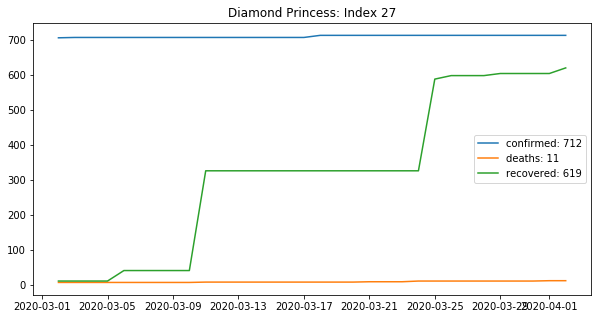

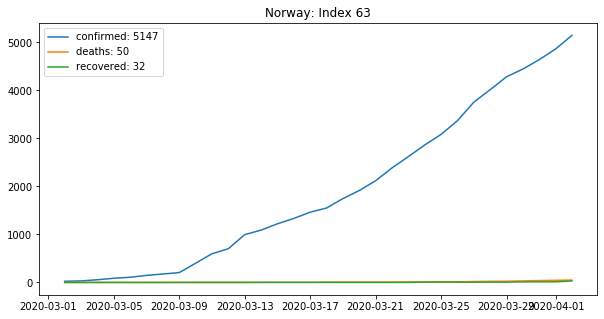

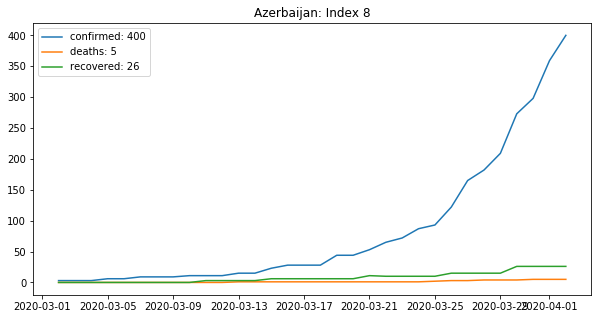

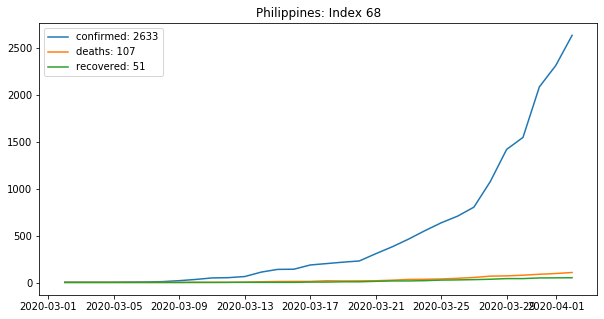

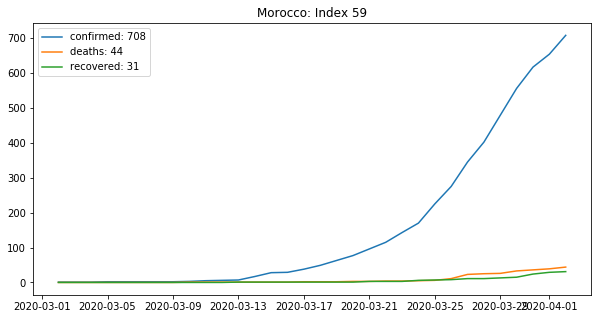

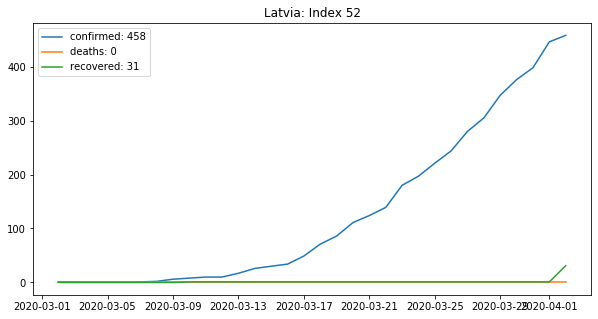

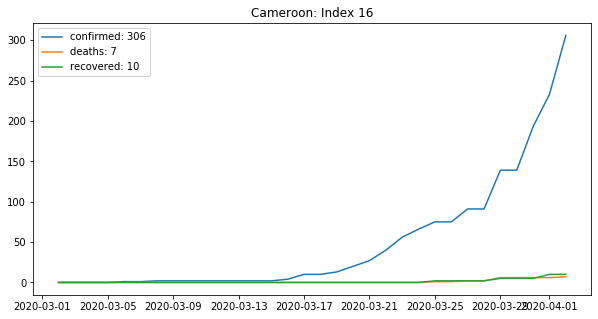

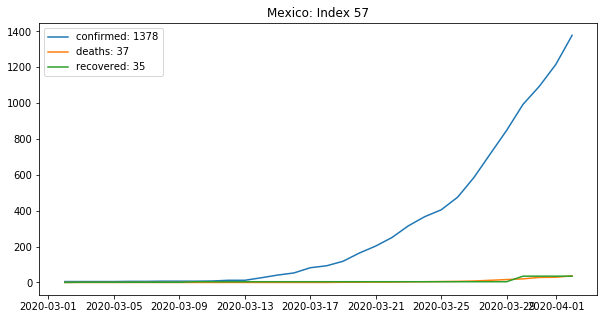

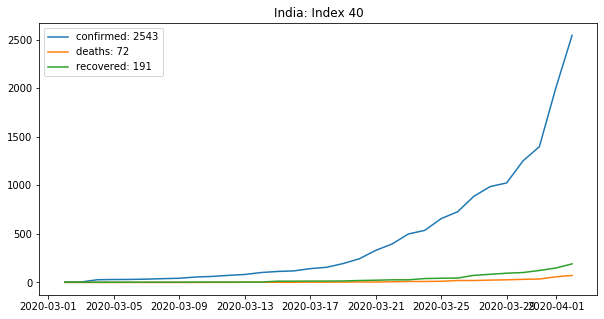

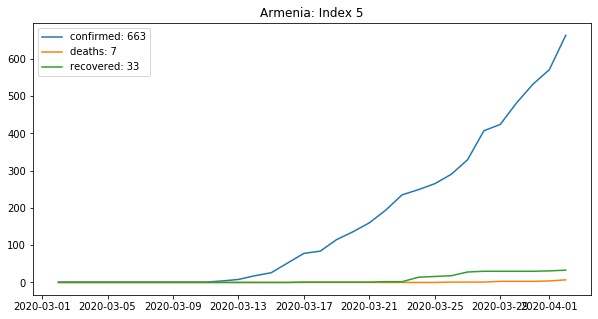

In [458]:
sample_size = 10
sample = random.sample(range(data[0].shape[0]),sample_size)
for index in sample:
    country = data[0].iloc[index][0]
    df = pd.DataFrame([d.iloc[index][1:] for d in data], index=[0,1,2]).fillna(0)
    total = df.iloc[:,-1]
    df.set_axis(["confirmed: {}".format(total.loc[0]),"deaths: {}".format(total[1]),"recovered: {}".format(total[2])], inplace=True, axis=0)
    df.T[40:].plot(title=country + ': Index {}'.format(index))


In [414]:
L = ["Austria", "Ireland", "Germany", "Italy", "US"]
over_100 = [] #date at which country had over 100 infections
start_date+dt.timedelta(1)

datetime.date(2020, 3, 16)

Austria
Latest available data from date 2020-04-02: 11129
Reg score 0.9566311398019589
Reg coeff [[0.1466245]]
Intercept [7.01105741]
Prediction for 2020-04-02:  [[15526.42138905]]
Actual value:  7    11129.0
Name: 2020-04-02, dtype: float64
Prediction for 2020-04-03:  [[17978.33966562]]
Ireland
Latest available data from date 2020-04-02: 3849
Reg score 0.9420355232228106
Reg coeff [[0.18366906]]
Intercept [5.3076533]
Prediction for 2020-04-02:  [[5506.56545201]]
Actual value:  44    3849.0
Name: 2020-04-02, dtype: float64
Prediction for 2020-04-03:  [[6616.78867971]]
Germany
Latest available data from date 2020-04-02: 84794
Reg score 0.9644026358818026
Reg coeff [[0.14516628]]
Intercept [8.97825934]
Prediction for 2020-04-02:  [[108147.60567145]]
Actual value:  34    84794.0
Name: 2020-04-02, dtype: float64
Prediction for 2020-04-03:  [[125043.70150106]]
Italy
Latest available data from date 2020-04-02: 115242
Reg score 0.9623723649947307
Reg coeff [[0.08569912]]
Intercept [10.2727982

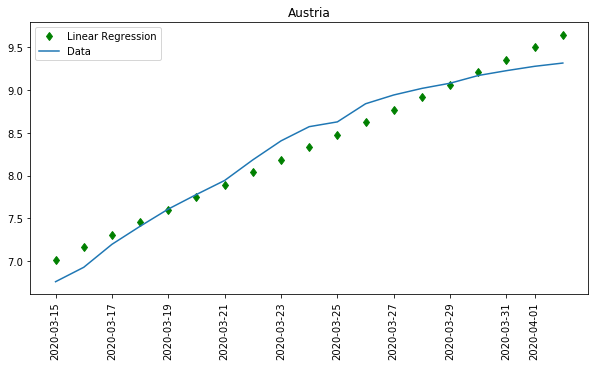

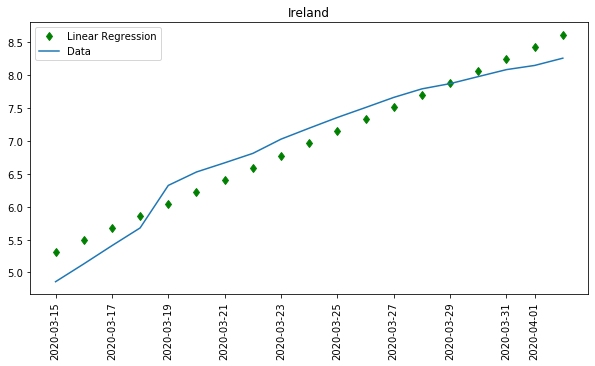

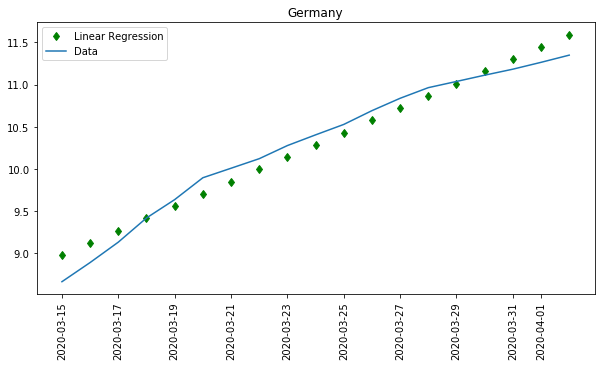

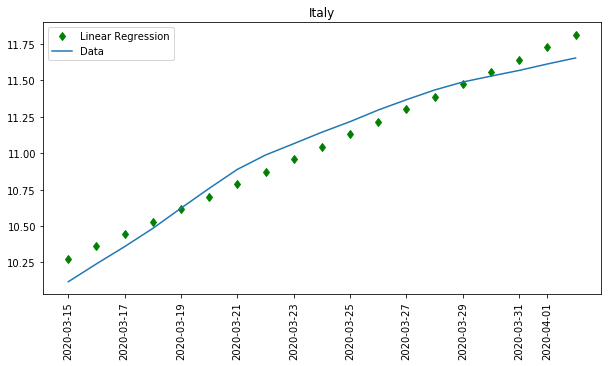

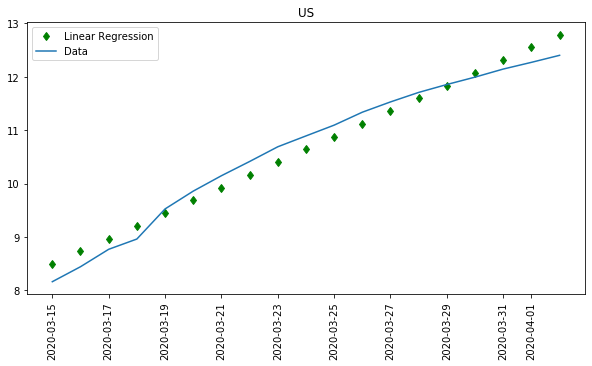

In [459]:
from sklearn.linear_model import LinearRegression
#import statsmodels.formula.api as sm
for country in L:
    y = data[0].loc[data[0]["Country/Region"]==country].iloc[:,1:].transpose()
    start_date = dt.date(2020,3,15)
    y = y.loc[start_date:today]
    y = y[y!=0].dropna().apply(np.log)
    #y = y.append(pd.Series({y.columns[0]:np.log(newest_data[country])}, name=pd.datetime(20,3,17)))
    X = np.array(range(y.shape[0])).reshape(-1,1)
    reg = LinearRegression()
    reg.fit(X,y)
    print(country)
    print('Latest available data from date {}: {}'.format(data[0].columns[-1], data[0].loc[data[0]["Country/Region"]==country].iloc[0,-1]))
    print('Reg score', reg.score(X, y))
    print('Reg coeff', reg.coef_)
    print('Intercept', reg.intercept_)
    plt.figure()
    plt.plot(y.index,(reg.predict(X)), 'gd', label='Linear Regression')
    plt.plot(y.index, (np.array(y)), label='Data')
    plt.title(country)
    plt.legend(loc="best")
    plt.xticks(rotation='vertical')
    print('Prediction for {}: '.format(data[0].columns[-1]), np.exp(reg.predict((X[-1]).reshape(-1,1))))
    print('Actual value: ', np.exp(y.iloc[-1]))
    print('Prediction for {}: '.format(data[0].columns[-1]+dt.timedelta(1)), np.exp(reg.predict((X[-1]+1).reshape(-1,1))))
    
    #reg.predict(np.array([[3, 5]]))

## Let's divide the data by population size. 
We can either add the population value (from the year 2016) to the data, as is demonstrated below or just find the population_data when we need it.

One can also try to merge with the following command:
pd.merge(data[0], population_data,  how='inner', left_on='Country/Region', right_on='Country Name',
         sort=True, suffixes=('_x', '_y'), copy=True)

In [416]:
population_data = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')

In [417]:
countries = data[0]['Country/Region']

In [418]:
population_data = population_data.drop([i for i in range(population_data.shape[0]) if population_data.iloc[i]['Year']<2016])

In [419]:
population_data = population_data.set_index('Country Name').drop(['Year','Country Code'],axis=1)

In [420]:
#Some Countries in population_data have other names
for i,c in countries.iteritems():
    if c not in population_data.index.values: print(c)

Czechia
Diamond Princess
Egypt
Iran
Korea, South
North Macedonia
Russia
Slovakia
Taiwan*
US


In [421]:
population_data.loc[population_data.index.str.contains('Mace')]

,Value
Country Name,
"Macedonia, FYR",2081206.0


In [422]:
population_data = population_data.rename(index={'Macedonia, FYR':'North Macedonia','Iran, Islamic Rep.':'Iran','Egypt, Arab Rep.':'Egypt','Czech Republic':'Czechia','United States':'US', 'Russian Federation':'Russia', 'Korea, Rep.' : 'Korea, South', 'Slovak Republic':'Slovakia'})

In [423]:
population_data = population_data.drop([population_data.index[i] for i in range(population_data.shape[0]) if population_data.index[i] not in countries.values])

In [424]:
taiwan_population = 23574274; diamond_princess_population = 3600

In [425]:
population_data.loc['Taiwan*'] = taiwan_population
population_data.loc['Diamond Princess'] = diamond_princess_population

In [426]:
data[0] = data[0].set_index('Country/Region')

In [428]:
def divide_by_population(x):
    country = x.name
    population = population_data.loc[country].values
    return x/population*100000

infections_relative = data[0].apply(divide_by_population,axis=1)

## Let's look at the 15 most infected countries (relatively and according to reported numbers...). 
We exclude the first four because they are small: Diamond Princess, San Marino, Andorra, Luxembourg

In [471]:
most_infected = infections_relative.sort_values(axis=0, by=infections_relative.columns[-1], ascending=False)[4:20]

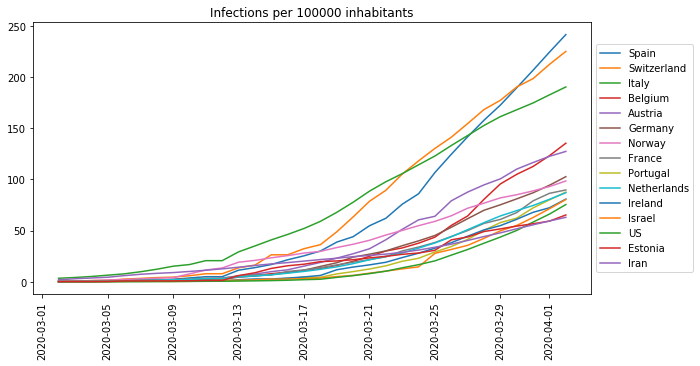

In [460]:
f = plt.figure()
plt.title('Infections per 100000 inhabitants')
most_infected.T[40:].plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
plt.xticks(rotation='vertical')
plt.show()

## Let's look at a new graph: The start date for every country is set to the first date it reaches infection_threshhold infected per 100000 inhabitants

In [489]:
infection_threshhold = 20

In [482]:
x = most_infected.loc['Iceland']

In [487]:
x[dt.date(2020, 3, 10):]

2020-03-10     20.643108
2020-03-11     25.429915
2020-03-12     30.815074
2020-03-13     40.089513
2020-03-14     46.671374
2020-03-15     51.159006
2020-03-16     53.851585
2020-03-17     65.818604
2020-03-18     74.793868
2020-03-19     98.727906
2020-03-20    122.362768
2020-03-21    141.509998
2020-03-22    169.931668
2020-03-23    175.915178
2020-03-24    193.865706
2020-03-25    220.492323
2020-03-26    239.938729
2020-03-27    266.266170
2020-03-28    288.105980
2020-03-29    305.158982
2020-03-30    324.904563
2020-03-31    339.564161
2020-04-01    364.994076
2020-04-02    394.612448
Name: Iceland, dtype: float64

In [493]:
x.reset_index?

In [ ]:
most_infected.loc['Iceland'].plot

No handles with labels found to put in legend.


0      20.643108
1      25.429915
2      30.815074
3      40.089513
4      46.671374
5      51.159006
6      53.851585
7      65.818604
8      74.793868
9      98.727906
10    122.362768
11    141.509998
12    169.931668
13    175.915178
14    193.865706
15    220.492323
16    239.938729
17    266.266170
18    288.105980
19    305.158982
20    324.904563
21    339.564161
22    364.994076
23    394.612448
Name: Iceland, dtype: float64


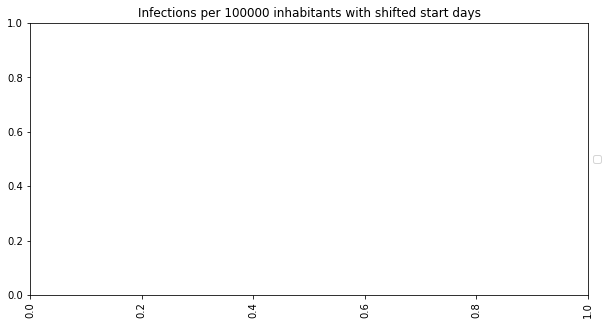

In [494]:
f = plt.figure()
plt.title('Infections per 100000 inhabitants with shifted start days')
for i in most_infected.index:
    start = most_infected.loc[i].ge(infection_threshhold).idxmax()
    tmp = most_infected.loc[i][start:].reset_index(drop=True)
    #print(tmp)
    #break
    tmp.plot()
    
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
plt.xticks(rotation='vertical')
plt.show()